In [1]:
import geopandas
from shapely.geometry import Polygon, MultiPolygon
import pandas as pd
from urllib.request import urlopen
import json
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.pyplot as plt

### Load and organize California county outline coordinates

In [2]:
with urlopen('https://raw.githubusercontent.com/plotly/datasets/master/geojson-counties-fips.json') as response:
    counties = json.load(response)

In [3]:
ca_county_features = []

for i in range(len(counties['features'])):
    if counties['features'][i]['id'][0:2] == '06':
        ca_county_features.append(counties['features'][i])

### Define function to make shapely polygons

In [4]:
def mk_poly(coords):
    verts = []
    for pair in coords:
        verts.append(tuple(pair))
    return Polygon(verts)

### Make a list of county polygons

In [5]:
names = []
poly_list = []
for i in range(len(ca_county_features)):
    if len(ca_county_features[i]['geometry']['coordinates']) > 1:
        nu_poly = []
        for j in range(len(ca_county_features[i]['geometry']['coordinates'])):
            sub_poly = mk_poly(ca_county_features[i]['geometry']['coordinates'][j][0])
            nu_poly.append(sub_poly)
        nu_poly = MultiPolygon(nu_poly)
        names.append(ca_county_features[i]['properties']['NAME'])
    elif len(ca_county_features[i]['geometry']['coordinates'][0]) == 1:
        nu_poly = mk_poly(ca_county_features[i]['geometry']['coordinates'][0][0])
        names.append(ca_county_features[i]['properties']['NAME'])
    else:
        nu_poly = mk_poly(ca_county_features[i]['geometry']['coordinates'][0])
        names.append(ca_county_features[i]['properties']['NAME'])
    poly_list.append(nu_poly)

### Make dataframe of county polygons

In [6]:
df = pd.DataFrame({'name':names,'geometry':poly_list})
df.head(2)

,name,geometry
0,Amador,"POLYGON ((-120.995497 38.225405, -121.027084 3..."
1,Glenn,"POLYGON ((-122.937654 39.798156, -122.046471 3..."


In [7]:
county = geopandas.GeoDataFrame(df,geometry='geometry')

### merge with data

In [8]:
county = county.sort_values('name')
county['name'] = county['name'].str.lower()
ind = list(range(58))
county['ind'] = ind
county.set_index('ind',inplace=True)
county.head(2)

,name,geometry
ind,,
0,alameda,"POLYGON ((-121.85576 37.48454, -122.04527 37.4..."
1,alpine,"POLYGON ((-120.07239 38.70277, -119.88030 38.8..."


### Readin in elecricity usage data

In [9]:
cons = pd.read_csv('datasets/ElectricityByCounty.csv')
cons.head(2)

,County,Sector,2018,Total Usage
0,ALAMEDA,Total,10417.109747,10417.109747
1,ALPINE,Total,18.704208,18.704208


In [10]:
cons = cons.sort_values('County')
cons['County'] = cons['County'].str.lower()
cons.rename(columns={'County':'name'},inplace=True)
cons.drop(columns = ['Sector','2018'],inplace=True)
cons.head(2)

,name,Total Usage
0,alameda,10417.109747
1,alpine,18.704208


In [11]:
county = county.merge(cons,on='name')
county.head(2)

,name,geometry,Total Usage
0,alameda,"POLYGON ((-121.85576 37.48454, -122.04527 37.4...",10417.109747
1,alpine,"POLYGON ((-120.07239 38.70277, -119.88030 38.8...",18.704208


### Make function to plot map data

In [12]:
def county_plot(gdf,colname):
    fig, ax = plt.subplots(1, 1,figsize=(10,10))
    plt.title(colname,fontsize=24)
    plt.xlabel('Longitude',fontsize=18)
    plt.ylabel('Latitude',fontsize=18)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    gdf.plot(column=colname, ax=ax, legend=True, cax=cax, cmap='viridis')

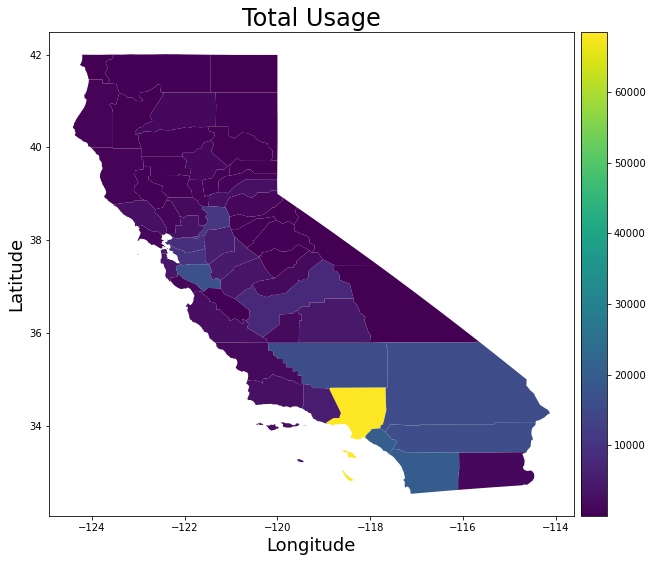

In [25]:
county_plot(county,'Total Usage')
# plt.savefig('./images/total_usage.png',dpi=235,bbox_inches='tight');

### Readin population data and merge

In [14]:
pop = pd.read_csv('datasets/county_census.csv')
pop.head(2)

,CTYNAME,Pop,GrowthRate
0,Los Angeles County,10105518,2.8820
1,San Diego County,3343364,7.7356


In [15]:
pop.rename(columns={'CTYNAME':'name'},inplace=True)
pop['name'] = pop['name'].str.replace(' County','').str.lower()
pop.head(2)

,name,Pop,GrowthRate
0,los angeles,10105518,2.8820
1,san diego,3343364,7.7356


In [16]:
county = county.merge(pop,on='name')
county.head(2)

,name,geometry,Total Usage,Pop,GrowthRate
0,alameda,"POLYGON ((-121.85576 37.48454, -122.04527 37.4...",10417.109747,1666753,10.159
1,alpine,"POLYGON ((-120.07239 38.70277, -119.88030 38.8...",18.704208,1101,-5.168


In [17]:
county['Per Capita Usage'] = county['Total Usage']/county['Pop']

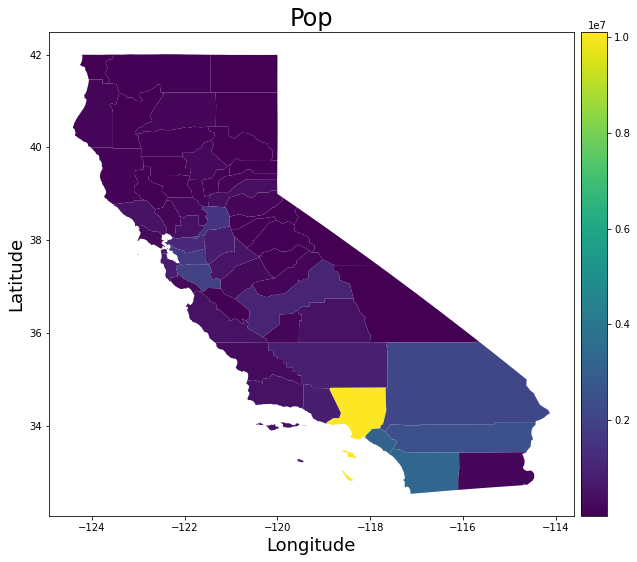

In [18]:
county_plot(county,'Pop')

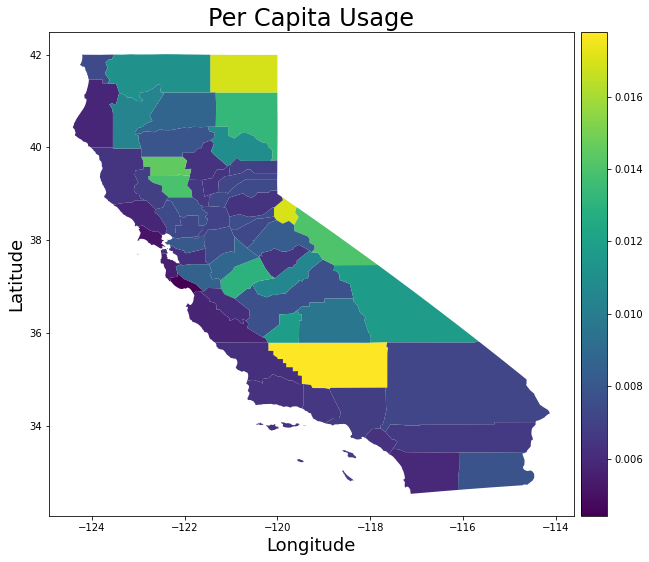

In [26]:
county_plot(county,'Per Capita Usage')
# plt.savefig('./images/pc_usage.png',dpi=235,bbox_inches='tight');

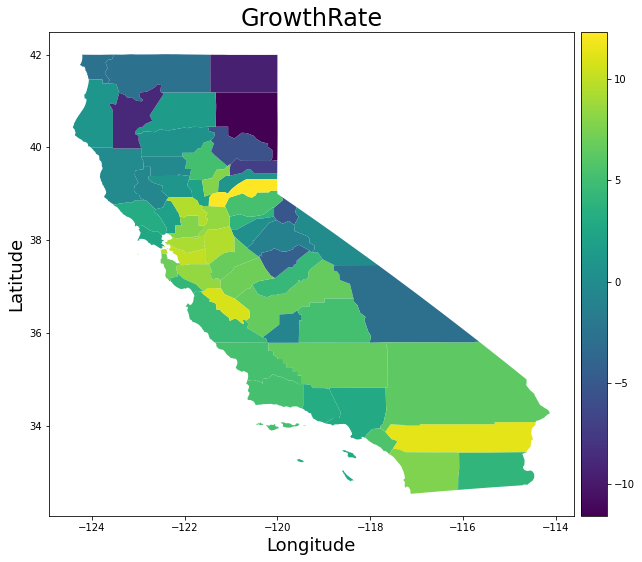

In [27]:
county_plot(county,'GrowthRate')
plt.savefig('./images/growth.png',dpi=235,bbox_inches='tight');

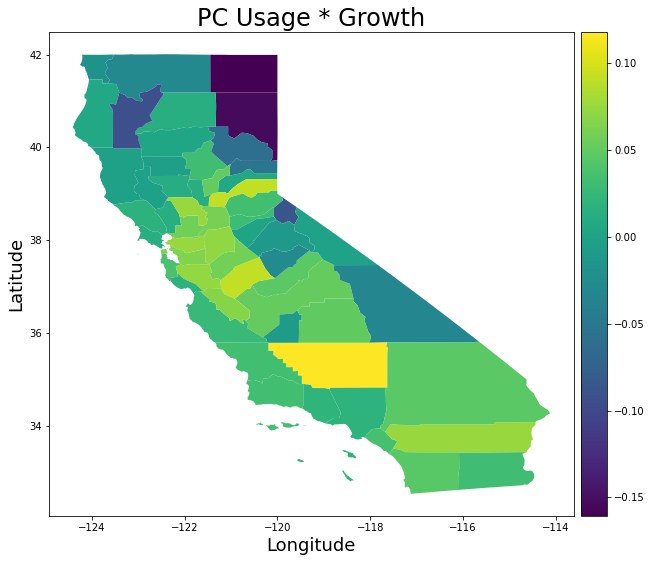

In [21]:
county['PC Usage * Growth'] = county['Per Capita Usage'] * county['GrowthRate']
county_plot(county,'PC Usage * Growth')

### Add in powerplant data

In [22]:
gen = pd.read_csv('datasets/county_gen14.csv')
gen['name'] = gen['name'].str.lower()

In [23]:
county = county.merge(gen,on='name',how='left')
county.head(2)

,name,geometry,Total Usage,Pop,GrowthRate,Per Capita Usage,PC Usage * Growth,generation_14
0,alameda,"POLYGON ((-121.85576 37.48454, -122.04527 37.4...",10417.109747,1666753,10.159,0.006250,0.063493,1181.3
1,alpine,"POLYGON ((-120.07239 38.70277, -119.88030 38.8...",18.704208,1101,-5.168,0.016988,-0.087796,NaN


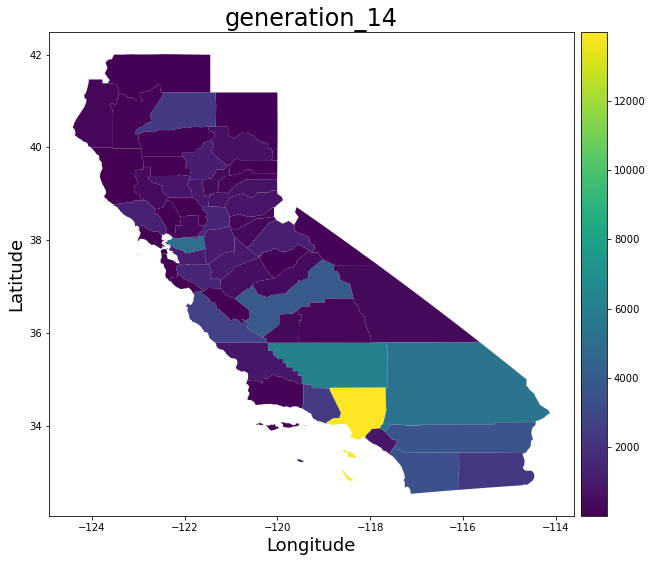

In [24]:
county_plot(county,'generation_14')

### Save data to file

In [113]:
county.to_file("datasets/county_agg.geojson", driver='GeoJSON')